This notebook is for demo-ing using `neuron` in `python`.

The model is the simple HH model. Usually you would be able to `insert` and load in the modebl by doing: `soma.insert('hh')` (see [here](https://neuron.yale.edu/neuron/docs/scripting-neuron-basics) for more information). 

However, for the purpose of demo-ing how to integrate with custom `.mod` files (like from [modeldb](https://senselab.med.yale.edu/modeldb) or self-designed files), we are going to use `.mod` files from [modeldb](https://senselab.med.yale.edu/modeldb/ShowModel?model=3434&file=/cdlab/#tabs-1). 

Please ignore the actual values, I didn't have time to double-check the realistic values (sorry). In practice, always try to keep track of the values, physiological ranges, units and the sources which are used in the model. 

Before running the notebook or the line `from neuron import h`, compile the files first by running this in terminal: `nrnivmodl` OR the following cell. 
It will create another folder of the compiled files.

In [1]:
%%capture
!nrnivmodl

In [2]:
%%capture
from neuron import h #, gui
import numpy as np # when dealing with more complicated operations 
import pickle, time, os # not important but usually would be helpful 
from matplotlib import pyplot as plt # for plotting 
from neuron.units import ms, mV # might need sometimes 
h.load_file('stdrun.hoc') 

This notebook contains 2 ways of "communicating" with `neuron` below. 

``` python
# way 1: via python-neuron API
soma = h.Section(name='soma')

# way 2: passing neuron codes to the object `h` imported from `neuron` above 
h('''
create soma 
''')
soma = h.soma # get the reference out 
```

In [3]:
# warning, some units might be off
# in practice double check units + conversion 

# Create soma and insert channels 
h('''
    celsius = 20
    dt = 0.01
    
    v_init = -69
    tstop = 150
    
    create soma
    soma {
        insert pas 
        e_pas = -50 
        g_pas = 3e-5
        
        insert nahh 
        ena = 55
        gnabar_nahh = 0.12

        insert khh 
        ek=-72
        gkbar_khh = 0.036
    }
''')

# get reference to 
soma = h.soma 

In [4]:
# try accessing internal variables
print(soma(0.5).ena)
print(soma(0.5).g_pas)
print(soma(0.5).gnabar_nahh)


55.0
3e-05
0.12


In [5]:
# Create a current stimulation
iclamp = h.IClamp(soma(0.5))
iclamp.delay = 20
iclamp.dur = 100
iclamp.amp = 8

In [6]:
# Create monitoring variables to record 
# need to insert the `_ref_` before the variables to record to access the reference

v = h.Vector().record(soma(0.5)._ref_v) 
t = h.Vector().record(h._ref_t) 

m_hh = h.Vector().record(soma(0.5)._ref_m_nahh)
h_hh = h.Vector().record(soma(0.5)._ref_h_nahh)
ina_hh = h.Vector().record(soma(0.5)._ref_ina)

n_hh = h.Vector().record(soma(0.5)._ref_n_khh)
ik_hh = h.Vector().record(soma(0.5)._ref_ik)

i_leak = h.Vector().record(soma(0.5)._ref_i_pas)

In [7]:
# Run simulation
h('finitialize(v_init)')
h.continuerun(h.tstop) # or `h.continuerun(150 ms)


	1 


0.0

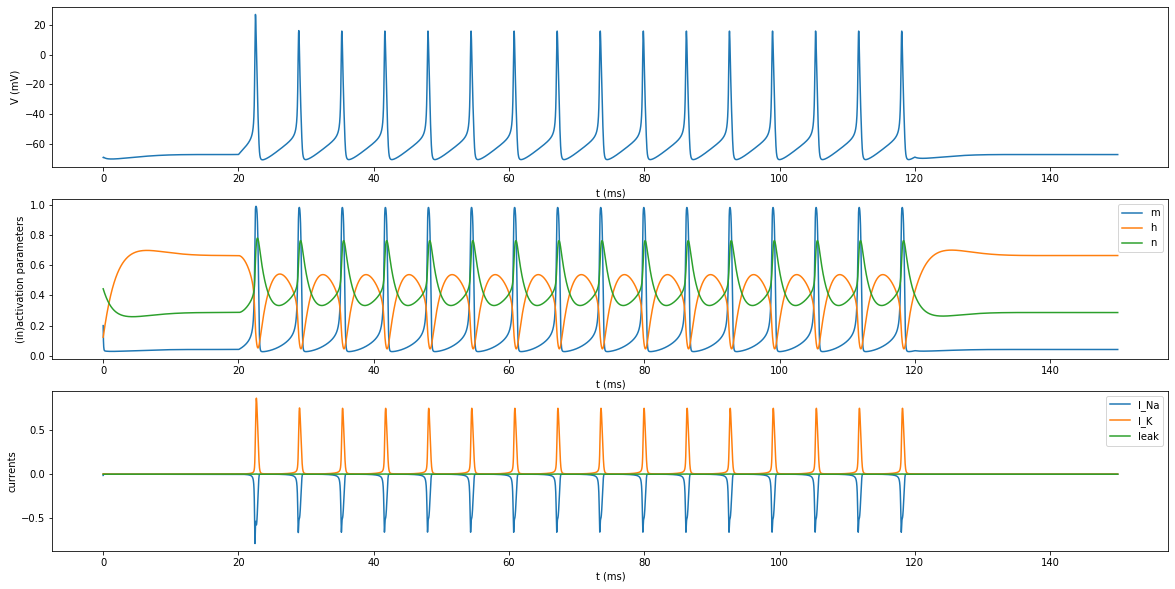

In [9]:
# Plotting
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(t, v)
plt.xlabel('t (ms)')
plt.ylabel('V (mV)')

plt.subplot(312)
plt.plot(t, m_hh, label='m')
plt.plot(t, h_hh, label='h')
plt.plot(t, n_hh, label='n')
plt.xlabel('t (ms)')
plt.ylabel('(in)activation parameters')
plt.legend()

plt.subplot(313)
plt.plot(t, ina_hh, label='I_Na')
plt.plot(t, ik_hh, label='I_K')
plt.plot(t, i_leak, label='leak')
plt.xlabel('t (ms)')
plt.ylabel('currents')
plt.legend()

plt.show()